## Sổ tay Huấn luyện DGI với GraphAlign (Phiên bản Padding Chuẩn hóa)

Đây là phiên bản cập nhật sử dụng phương pháp **Canonical Feature Set (Tập Đặc trưng Chuẩn)**.

**Logic mới:**
1.  Chúng ta định nghĩa `MAX_N_FEATURES = 50` và `MAX_E_FEATURES = 50`.
2.  Các đặc trưng (ví dụ: 2 đặc trưng `[state, priority]`) sẽ được "đệm" (pad) lên 50, sử dụng một giá trị đánh dấu `MARKER_VALUE` (ví dụ: -999.0).
3.  Một hàm `normalize_and_pad_batch` mới sẽ **chuẩn hóa từng cột đặc trưng**, nhưng **bỏ qua** `MARKER_VALUE` khi tính `mean` và `std`.
4.  Sau khi chuẩn hóa, các vị trí `MARKER_VALUE` sẽ được thay bằng `0.0` (trung tính) trước khi đưa vào GNN.

In [1]:
# Import essential libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import dgl
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import os # Thêm thư viện OS để tạo thư mục
from utils.attack_algo_utils import *
from utils.graph_utils import *
from utils.utils import *
# Import các lớp GraphAlign từ tệp graph_utils.py của bạn
# Đảm bảo tệp graph_utils.py nằm trong cùng thư mục

print("Đã import các thư viện và các lớp GraphAlign.")

Using device: cuda
Đã import các thư viện và các lớp GraphAlign.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# --- 1. Tạo dữ liệu cho hai đồ thị mạng khác nhau ---
# (Đây là code GỐC từ yêu cầu của bạn)
    
# Đồ thị 1 (Lấy từ Graph.ipynb của bạn)
G_original = nx.DiGraph()
G_original.add_nodes_from(["Data Server", "Pad", "Web Server", "Host 1", "Host 2", "Host 3", "File Server", "Router"])
node_attributes = {
    "Data Server": {"state": 0, "priority": 2}, "Pad": {"state": 0, "priority": 1},
    "Web Server": {"state": 0, "priority": 1}, "Host 1": {"state": 0, "priority": 1},
    "Host 2": {"state": 0, "priority": 0}, "Host 3": {"state": 0, "priority": 0},
    "File Server": {"state": 0, "priority": 0}, "Router": {"state": 0, "priority": 2}
}
nx.set_node_attributes(G_original, node_attributes)
edges = [
    ("Pad", "Host 1", {"user": 0.6, "root": 0.48}), ("Pad", "Host 2", {"user": 0.32, "root": 0.32}),
    ("Pad", "Host 3", {"user": 0.32, "root": 0.32}), ("Pad", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Pad", {"user": 0.6, "root": 0.6}), ("Host 1", "Web Server", {"user": 0.8, "root": 0.6}),
    ("Host 1", "Host 2", {"user": 0.32, "root": 0.32}), ("Host 1", "Host 3", {"user": 0.32, "root": 0.32}),
    ("Host 2", "Host 3", {"user": 0.8, "root": 0.8}), ("Host 2", "File Server", {"user": 0.8, "root": 0.6}),
    ("Host 2", "Data Server", {"user": 0.8, "root": 0.6}), ("Host 3", "Host 2", {"user": 0.8, "root": 0.8}),
    ("Host 3", "File Server", {"user": 0.8, "root": 0.6}), ("Host 3", "Data Server", {"user": 0.8, "root": 0.6}),
    ("Web Server", "File Server", {"user": 0.8, "root": 0.04}), ("Web Server", "Data Server", {"user": 0.8, "root": 0.04}),
    ("File Server", "Data Server", {"user": 0.8, "root": 0.04}), ("Data Server", "File Server", {"user": 0.6, "root": 0.02}),
    ("Router", "Web Server", {"user": 0.9, "root": 0.9}), ("Web Server", "Router", {"user": 0.9, "root": 0.9}),
    ("Router", "Data Server", {"user": 0.9, "root": 0.1}), ("Data Server", "Router", {"user": 0.9, "root": 0.9}),
    ("Pad", "Router", {"user": 0.7, "root": 0.5}),
]
G_original.add_edges_from(edges)

g1 = dgl.from_networkx(G_original)
# ----- QUAN TRỌNG: Lưu các biến ánh xạ ----- 
node_order = list(G_original.nodes()) # Lưu lại thứ tự node để hiển thị
node_map = {name: i for i, name in enumerate(node_order)} # Tạo map từ Tên -> Index
original_edges_list = list(G_original.edges()) # Lưu lại thứ tự cạnh
# ------------------------------------------
nfeats1 = torch.tensor([[G_original.nodes[n]['state'], G_original.nodes[n]['priority']] for n in node_order], dtype=torch.float32)
efeats1 = torch.tensor([[d['user'], d['root']] for u, v, d in G_original.edges(data=True)], dtype=torch.float32)
g1.ndata['h'] = nfeats1
g1.edata['h'] = efeats1

# 3. Tạo Đồ thị 2 (ví dụ: mạng văn phòng nhỏ với thang đo đặc trưng khác)
G_2 = nx.DiGraph()
G_2.add_nodes_from(["WAN", "DMZ Server", "User PC 1", "User PC 2"])
node_attr_2 = {
    "WAN": {"state": 0, "priority": 2}, 
    "DMZ Server": {"state": 1, "priority": 1},
    "User PC 1": {"state": 0, "priority": 0},
    "User PC 2": {"state": 0, "priority": 0}
}
nx.set_node_attributes(G_2, node_attr_2)
edges_2 = [
    ("WAN", "DMZ Server", {"user": 0.9, "root": 0.8}), 
    ("DMZ Server", "User PC 1", {"user": 0.6, "root": 0.5}),
    ("DMZ Server", "User PC 2", {"user": 0.2, "root": 0.5}),
    ("User PC 1", "User PC 2", {"user": 0.3, "root": 0.6})
]
G_2.add_edges_from(edges_2)
g2 = dgl.from_networkx(G_2)
nfeats2 = torch.tensor([[G_2.nodes[n]['state'], G_2.nodes[n]['priority']] for n in G_2.nodes()], dtype=torch.float32)
efeats2 = torch.tensor([[d['user'], d['root']] for u, v, d in G_2.edges(data=True)], dtype=torch.float32)
g2.ndata['h'] = nfeats2
g2.edata['h'] = efeats2

print(f"Đã tạo G1: {g1.num_nodes()} nodes, {g1.num_edges()} edges. Đặc trưng: {nfeats1.shape}")
print(f"Đã tạo G2: {g2.num_nodes()} nodes, {g2.num_edges()} edges. Đặc trưng: {nfeats2.shape}")
print(f"\nNode Order (Ánh xạ Index -> Tên):\n{node_order}")
print(f"\nNode Map (Ánh xạ Tên -> Index):\n{node_map}")

Đã tạo G1: 8 nodes, 23 edges. Đặc trưng: torch.Size([8, 2])
Đã tạo G2: 4 nodes, 4 edges. Đặc trưng: torch.Size([4, 2])

Node Order (Ánh xạ Index -> Tên):
['Data Server', 'Pad', 'Web Server', 'Host 1', 'Host 2', 'Host 3', 'File Server', 'Router']

Node Map (Ánh xạ Tên -> Index):
{'Data Server': 0, 'Pad': 1, 'Web Server': 2, 'Host 1': 3, 'Host 2': 4, 'Host 3': 5, 'File Server': 6, 'Router': 7}


In [4]:
# --- CELL MỚI: Chuẩn bị Dữ liệu (Padding Chuẩn hóa) ---

# 1. Định nghĩa các hằng số
MAX_N_FEATURES = 50
MAX_E_FEATURES = 50
MARKER_VALUE = -999.0 # Giá trị đặc biệt để đánh dấu padding

# 2. Định nghĩa hàm Chuẩn hóa & Đệm (Cốt lõi của logic mới)
def normalize_and_pad_batch(feats_list, max_dim):
    """
    Hàm này lấy một danh sách các tensor đặc trưng (từ các đồ thị khác nhau),
    đệm chúng lên max_dim, sau đó chuẩn hóa từng cột một cách an toàn.
    """
    padded_tensors = []
    for feats in feats_list:
        num_nodes_or_edges, num_feats = feats.shape
        if num_feats > max_dim:
            raise ValueError(f"Đồ thị có {num_feats} đặc trưng, nhiều hơn MAX={max_dim}")
        
        # Tạo tensor nền với giá trị marker
        padded_tensor = torch.full((num_nodes_or_edges, max_dim), MARKER_VALUE, dtype=torch.float32)
        
        # Sao chép đặc trưng thật vào
        padded_tensor[:, :num_feats] = feats
        padded_tensors.append(padded_tensor)
    
    # Ghép tất cả các tensor đã đệm lại thành một batch lớn
    full_batch_tensor = torch.cat(padded_tensors, dim=0)
    normalized_batch_tensor = full_batch_tensor.clone()
    
    # 3. Chuẩn hóa từng cột một (Quan trọng!)
    for i in range(max_dim):
        col = full_batch_tensor[:, i]
        
        # Tạo mặt nạ (mask) để chỉ chọn các giá trị KHÔNG phải là marker
        valid_mask = (col != MARKER_VALUE)
        
        if valid_mask.any(): # Nếu có ít nhất một giá trị thật trong cột này
            valid_values = col[valid_mask]
            
            # Tính mean/std CHỈ trên các giá trị thật
            mean = valid_values.mean()
            std = valid_values.std() + 1e-6
            
            # Chuẩn hóa CHỈ các giá trị thật
            normalized_batch_tensor[valid_mask, i] = (valid_values - mean) / std
            
            # Đặt các giá trị marker thành 0.0 (trung tính) sau khi chuẩn hóa
            normalized_batch_tensor[~valid_mask, i] = 0.0
        else:
            # Nếu toàn bộ cột này là marker (padding), chỉ cần đặt là 0
            normalized_batch_tensor[:, i] = 0.0
            
    return normalized_batch_tensor

# 4. Tạo Batch huấn luyện (Sử dụng logic mới)
print("--- Bắt đầu chuẩn hóa & đệm batch ---")

# Xử lý Node Features
nfeats_batch = normalize_and_pad_batch([nfeats1, nfeats2], MAX_N_FEATURES)
nfeats_batch = nfeats_batch.to(device)

# Xử lý Edge Features
efeats_batch = normalize_and_pad_batch([efeats1, efeats2], MAX_E_FEATURES)
efeats_batch = efeats_batch.to(device)

# Batch các đồ thị
g_batch = dgl.batch([g1, g2])
g_batch = g_batch.to(device)

print(f"\nĐã tạo batch huấn luyện: {g_batch.num_nodes()} nodes, {g_batch.num_edges()} edges")
print(f"Batch feature dims (đã đệm): Node={nfeats_batch.shape}, Edge={efeats_batch.shape}")

--- Bắt đầu chuẩn hóa & đệm batch ---

Đã tạo batch huấn luyện: 12 nodes, 27 edges
Batch feature dims (đã đệm): Node=torch.Size([12, 50]), Edge=torch.Size([27, 50])


In [5]:
import torch.distributed as dist
if dist.is_initialized():
    print("✅ Distributed initialized:", dist.get_world_size(), "workers")
else:
    print("⚠️ Running FMoE in local mode (single process).")

⚠️ Running FMoE in local mode (single process).


In [6]:
# --- Training loop (SỬA ĐỔI VỚI PADDING CHUẨN HÓA) ---

# Lấy kích thước đầu vào TỐI ĐA (MAX_FEATURES)
NDIM_IN = MAX_N_FEATURES # 50
EDIM = MAX_E_FEATURES    # 50

# Lấy các tham số từ cell cũ của bạn
N_HIDDEN = 16
N_OUT = 24
N_LAYERS = 2
EPOCHS = 2000 
LEARNING_RATE = 0.001

# --- MỚI: Thêm tham số cho GraphAlign (MoF) ---
NUM_EXPERTS = 4 # Số lượng chuyên gia
TOP_K = 1       # Định tuyến Top-k

# Khởi tạo encoder và mô hình DGI (SỬ DỤNG CÁC LỚP MỚI)
encoder = EGraphSAGE_GraphAlign(
    NDIM_IN, EDIM, N_HIDDEN, N_OUT, N_LAYERS, 
    F.leaky_relu, NUM_EXPERTS, TOP_K
)
dgi_model = DGI_GraphAlign(encoder)
dgi_model = dgi_model.to(device)

# Khởi tạo optimizer
optimizer = torch.optim.Adam(dgi_model.parameters(), lr=LEARNING_RATE)

print("\n--- Bắt đầu quá trình huấn luyện DGI + GraphAlign (Canonical Padding) ---")
print(f"Kích thước đầu vào mô hình: Node={NDIM_IN}, Edge={EDIM}")

for epoch in range(EPOCHS):
    dgi_model.train()  # Chuyển mô hình sang chế độ huấn luyện
    optimizer.zero_grad()

    loss = dgi_model(g_batch, nfeats_batch, efeats_batch)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 200 == 0: 
        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

print("--- Huấn luyện hoàn tất! ---")

Running FMOE
Running FMOE

--- Bắt đầu quá trình huấn luyện DGI + GraphAlign (Canonical Padding) ---
Kích thước đầu vào mô hình: Node=50, Edge=50
Epoch [200/2000], Loss: 0.0657
Epoch [400/2000], Loss: 0.0124
Epoch [600/2000], Loss: 0.0082
Epoch [800/2000], Loss: 0.0054
Epoch [1000/2000], Loss: 0.0242
Epoch [1200/2000], Loss: 0.0034
Epoch [1400/2000], Loss: 0.0012
Epoch [1600/2000], Loss: 0.0084
Epoch [1800/2000], Loss: 0.0015
Epoch [2000/2000], Loss: 0.0056
--- Huấn luyện hoàn tất! ---


In [12]:
# --- Lấy graphs cuối cùng (SỬA ĐỔI) ---

print("--- Trích xuất Embedding cho đồ thị GỐC (sau khi huấn luyện) ---")

# Để chạy suy luận (inference) trên đồ thị GỐC (g1),
# chúng ta cũng phải áp dụng CHÍNH XÁC quy trình tiền xử lý:
# (Chuẩn hóa + Đệm lên 50)

# 1. Áp dụng hàm `normalize_and_pad_batch` CHỈ cho g1
# (Lưu ý: nfeats1 là tensor gốc [8, 2] từ cell 'define_graphs_cell')
nfeats1_processed = normalize_and_pad_batch([nfeats1], MAX_N_FEATURES)
nfeats1_processed =  nfeats1_processed.to(device)
efeats1_processed = normalize_and_pad_batch([efeats1], MAX_E_FEATURES)
efeats1_processed = efeats1_processed.to(device)
print(f"Đã xử lý G1 cho inference. Shape: Node={nfeats1_processed.shape}, Edge={efeats1_processed.shape}")

g1 = g1.to(device)
dgi_model = dgi_model.to(device)

dgi_model.eval()
with torch.no_grad():
    final_node_embeddings, final_edge_embeddings = dgi_model.encoder(
        g1, nfeats1_processed, efeats1_processed, corrupt=False
    )

# Chuyển về CPU trước khi dùng numpy
nodes_emb_np = final_node_embeddings.detach().cpu().numpy()
edges_emb_np = final_edge_embeddings.detach().cpu().numpy()


print("\n[THÀNH CÔNG] Đã trích xuất graphs từ mô hình đã huấn luyện.")

# --- Hiển thị dưới dạng bảng (Pandas) ---

print("\n--- Bảng Embedding cho các Nút (sau khi huấn luyện) ---")
node_emb_cols = [f'emb_{i}' for i in range(nodes_emb_np.shape[1])]
df_nodes = pd.DataFrame(nodes_emb_np, index=node_order, columns=node_emb_cols)
pd.set_option('display.max_columns', None)
print(df_nodes.iloc[:, :10]) # Chỉ in 10 cột đầu tiên cho ngắn gọn

print("\n--- Bảng Embedding cho các Cạnh (sau khi huấn luyện) ---")
edge_data = {
    'Source': [u for u, v in original_edges_list],
    'Destination': [v for u, v in original_edges_list]
}
df_edges = pd.DataFrame(edge_data, index=pd.Index([f'{u}->{v}' for u, v in original_edges_list]))
edge_emb_cols = [f'emb_{i}' for i in range(edges_emb_np.shape[1])]
df_edges_emb = pd.DataFrame(edges_emb_np, index=df_edges.index, columns=edge_emb_cols)
print(df_edges.join(df_edges_emb).iloc[:, :12]) # In 10 cột emb đầu tiên

--- Trích xuất Embedding cho đồ thị GỐC (sau khi huấn luyện) ---
Đã xử lý G1 cho inference. Shape: Node=torch.Size([8, 50]), Edge=torch.Size([23, 50])

[THÀNH CÔNG] Đã trích xuất graphs từ mô hình đã huấn luyện.

--- Bảng Embedding cho các Nút (sau khi huấn luyện) ---
                emb_0     emb_1     emb_2     emb_3     emb_4     emb_5  \
Data Server -0.006312 -0.005629 -0.006110  1.067277 -0.000418 -0.001218   
Pad         -0.000795 -0.001181 -0.000907  0.466047  0.139401 -0.001448   
Web Server  -0.001100 -0.000013 -0.001736  0.308740  0.289249 -0.001612   
Host 1       0.034159  0.112421 -0.000629  0.227485  0.351451 -0.001634   
Host 2       0.141484  0.281497  0.063928  0.032161  0.420772 -0.001549   
Host 3       0.136272  0.245394  0.053554  0.076693  0.373663 -0.001693   
File Server -0.002548 -0.001800 -0.003785  0.505362  0.058548 -0.000656   
Router      -0.001806 -0.000965 -0.003175  0.837746 -0.000377 -0.002812   

                emb_6     emb_7     emb_8     emb_9  
D

In [13]:
# --- CELL MỚI: Xuất Dữ liệu cho Môi trường RL ---

print("--- Bắt đầu xuất file cho RL Agent ---")

# 1. Đặt tên thư mục (giống như trong Original.ipynb)
experiment_id = 1 # Bạn có thể thay đổi ID này
BASE_PATH = f'graphs/{experiment_id}'
os.makedirs(BASE_PATH, exist_ok=True)
print(f"Sẽ lưu vào thư mục: {BASE_PATH}")

# 2. Xác định các đường dẫn file
NODE_EMB_PATH = f"{BASE_PATH}/node_embeddings.npy"
EDGE_EMB_PATH = f"{BASE_PATH}/edge_embeddings.npy"
ENV_PATH = f"{BASE_PATH}/graph_environment.pth"
CONFIG_PATH = f"{BASE_PATH}/model_config.pth" # File cấu hình GNN
MODEL_STATE_PATH = f"{BASE_PATH}/dgi_model_state_dict.pth" # File trọng số GNN

# 3. Lấy dữ liệu (từ các cell trước)
# nodes_emb_np (từ cell 'inference_cell')
# edges_emb_np (từ cell 'inference_cell')
# G_original, g1, nfeats1, efeats1 (từ cell 'define_graphs_cell')
# node_order, node_map, original_edges_list (từ cell 'define_graphs_cell')
# dgi_model, encoder (từ cell 'training_loop_cell')

# 4. Lưu các Embedding (dạng .npy)
np.save(NODE_EMB_PATH, nodes_emb_np)
np.save(EDGE_EMB_PATH, edges_emb_np)
print(f"Đã lưu Node Embeddings vào: {NODE_EMB_PATH}")
print(f"Đã lưu Edge Embeddings vào: {EDGE_EMB_PATH}")

# 5. Lưu Môi trường Tĩnh (dạng .pth)
# Bao gồm các thông tin phi-tensor mà RL agent cần
env_data = {
    "G_original": G_original,     # Đồ thị NetworkX
    "g1": g1,                     # Đồ thị DGL gốc (chưa xử lý)
    "node_features_original": nfeats1, # Đặc trưng node gốc (tensor [8, 2])
    "edge_features_original": efeats1, # Đặc trưng cạnh gốc (tensor [25, 2])
    "node_order": node_order,     # List: ["Data Server", "Pad", ...]
    "node_map": node_map,       # Dict: {"Data Server": 0, ...}
    "original_edges_list": original_edges_list # List: [("Pad", "Host 1"), ...]
}
torch.save(env_data, ENV_PATH)
print(f"Đã lưu Môi trường Tĩnh (ánh xạ) vào: {ENV_PATH}")

# 6. Lưu Cấu hình Model GNN
# (Lấy từ cell 'training_loop_cell')
model_config = {
    "NDIM_IN": NDIM_IN, # 50
    "EDIM": EDIM,       # 50
    "N_HIDDEN": N_HIDDEN,
    "N_OUT": N_OUT,
    "N_LAYERS": N_LAYERS,
    "NUM_EXPERTS": NUM_EXPERTS,
    "TOP_K": TOP_K
}
torch.save(model_config, CONFIG_PATH)
print(f"Đã lưu Cấu hình Model vào: {CONFIG_PATH}")

# 7. Lưu Trọng số Model GNN
torch.save(dgi_model.state_dict(), MODEL_STATE_PATH)
print(f"Đã lưu Trọng số Model vào: {MODEL_STATE_PATH}")

print("\n--- XUẤT DỮ LIỆU HOÀN TẤT! ---")
print(f"Giờ bạn có thể chạy sổ tay 'Original.ipynb' với experiment_id = {experiment_id}")

--- Bắt đầu xuất file cho RL Agent ---
Sẽ lưu vào thư mục: graphs/1
Đã lưu Node Embeddings vào: graphs/1/node_embeddings.npy
Đã lưu Edge Embeddings vào: graphs/1/edge_embeddings.npy
Đã lưu Môi trường Tĩnh (ánh xạ) vào: graphs/1/graph_environment.pth
Đã lưu Cấu hình Model vào: graphs/1/model_config.pth
Đã lưu Trọng số Model vào: graphs/1/dgi_model_state_dict.pth

--- XUẤT DỮ LIỆU HOÀN TẤT! ---
Giờ bạn có thể chạy sổ tay 'Original.ipynb' với experiment_id = 1


In [15]:
# --- Trực quan hóa Mẫu Âm (SỬA ĐỔI) ---

print("--- Lấy Embedding Âm (Negative Embeddings) từ DGI ---")

dgi_model.eval()
with torch.no_grad():
    # Chạy encoder ở chế độ `corrupt=True` trên đồ thị gốc (đã xử lý)
    _, negative_edge_embeddings = dgi_model.encoder(g1, nfeats1_processed, efeats1_processed, corrupt=True)

# Chuyển về CPU trước khi .numpy()
negative_embeddings_np = negative_edge_embeddings.detach().cpu().numpy()

# Hiển thị dưới dạng bảng
print("\n--- Bảng Embedding cho các Cạnh Âm (từ DGI) ---")
edge_labels = [f'{u} -> {v} (âm)' for u,v in original_edges_list]
edge_emb_cols = [f'emb_{i}' for i in range(negative_embeddings_np.shape[1])]
df_negative_edges = pd.DataFrame(negative_embeddings_np, index=edge_labels, columns=edge_emb_cols)

pd.set_option('display.max_columns', None)
print(df_negative_edges.iloc[:, :10])  # Chỉ in 10 cột đầu tiên


--- Lấy Embedding Âm (Negative Embeddings) từ DGI ---

--- Bảng Embedding cho các Cạnh Âm (từ DGI) ---
                                    emb_0     emb_1     emb_2     emb_3  \
Data Server -> File Server (âm)  1.028656  0.911371  0.692797  0.995789   
Data Server -> Router (âm)       1.084545  0.970454  0.753133  1.046814   
Pad -> Host 1 (âm)               1.096377  0.798672  1.012257  1.531022   
Pad -> Host 2 (âm)               1.047942  0.778060  0.885506  1.407153   
Pad -> Host 3 (âm)               1.067352  0.922645  0.778512  1.002129   
Pad -> Web Server (âm)           0.903763  0.785425  0.646914  0.839891   
Pad -> Router (âm)               0.969574  0.844087  0.705967  0.912274   
Web Server -> File Server (âm)   0.796929  0.692212  0.563586  0.770049   
Web Server -> Data Server (âm)   1.077903  0.907888  0.831173  1.131971   
Web Server -> Router (âm)        0.852819  0.751295  0.623921  0.821074   
Host 1 -> Pad (âm)               1.487203  1.222785  0.939992  1.406439 

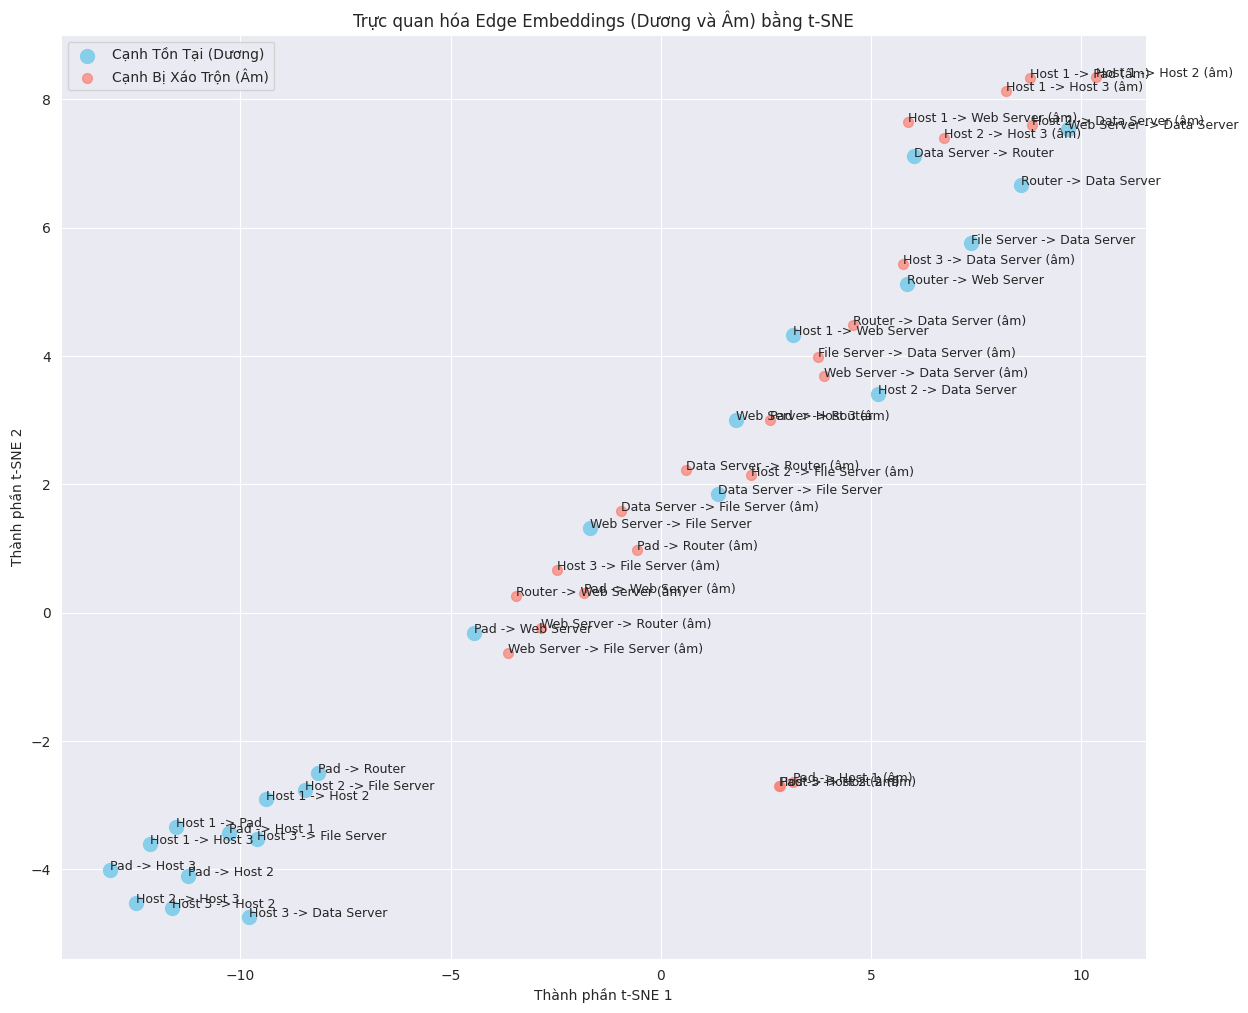

In [17]:
# --- Trực quan hóa t-SNE (Dương và Âm) ---

# Lấy embedding của các cạnh có thật (mẫu dương)
positive_embeddings_np = final_edge_embeddings.detach().cpu().numpy()  # <-- thêm .cpu()
positive_labels = [f'{u} -> {v}' for u, v in original_edges_list]
num_positive = len(positive_labels)

# Embedding âm đã tính ở cell trước, đã chuyển về CPU
# negative_embeddings_np = negative_edge_embeddings.detach().cpu().numpy()
negative_labels = [f'{u} -> {v} (âm)' for u, v in original_edges_list]

# Kết hợp tất cả embedding và chạy t-SNE
all_embeddings_np = np.vstack([positive_embeddings_np, negative_embeddings_np])
all_labels = positive_labels + negative_labels

# Chạy t-SNE trên toàn bộ dữ liệu
tsne = TSNE(n_components=2, random_state=42, perplexity=min(10, len(all_labels)-1))
embeddings_2d = tsne.fit_transform(all_embeddings_np)

# Vẽ biểu đồ với màu sắc khác nhau
plt.figure(figsize=(14, 12))

# Vẽ các điểm của cạnh có thật (màu xanh)
plt.scatter(embeddings_2d[:num_positive, 0], embeddings_2d[:num_positive, 1],
            c='skyblue', label='Cạnh Tồn Tại (Dương)', s=100)

# Vẽ các điểm của cạnh không tồn tại (màu đỏ)
plt.scatter(embeddings_2d[num_positive:, 0], embeddings_2d[num_positive:, 1],
            c='salmon', label='Cạnh Bị Xáo Trộn (Âm)', s=50, alpha=0.7)

# Thêm nhãn cho từng điểm
for i, label in enumerate(all_labels):
    plt.annotate(label, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=9)

plt.title('Trực quan hóa Edge Embeddings (Dương và Âm) bằng t-SNE')
plt.xlabel('Thành phần t-SNE 1')
plt.ylabel('Thành phần t-SNE 2')
plt.legend()
plt.grid(True)
plt.show()


**LƯU Ý VỀ CÁC CELL KHÁC:**

Các cell còn lại trong sổ tay của bạn (ví dụ: các cell trực quan hóa node và heatmap) có thể được giữ nguyên. Chúng đều hoạt động dựa trên biến `final_node_embeddings` và `final_edge_embeddings` được tạo ra trong cell `inference_cell`.